# Easygrad

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager

# helper
def plot(x, y=[], title=None):
    plt.figure(figsize=(7, 5))
    if title:
        plt.title(title)
    if y:
        for line in y:
            plt.plot(x, line[0], label=line[1])
    else:
        plt.plot(x)
    plt.grid(True)
    plt.legend()
    plt.show()

In [2]:
def subval(x, i, v):
    x_ = list(x)
    x_[i] = v
    return tuple(x_)

def subvals(x, ivs):
    x_ = list(x)
    for i, v in ivs:
        x_[i] = v
    return tuple(x_)

def find_top_boxed_args(args):
    top_trace_id = -1
    top_boxes = []
    for argnum, arg in enumerate(args):
        if isinstance(arg, ArrayBox):
            if arg._trace_id > top_trace_id:
                top_boxes = [(argnum, arg)]
                top_trace_id = arg._trace_id
            elif arg._trace_id == top_trace_id:
                top_boxes.append((argnum, arg))
    return top_boxes, top_trace_id

def primitive(f_raw):
    """Wraps a function so that its gradient (vjp) can be specified and its
    invocation can be recorded."""
    def f_wrapped(*args):
        PRINT = False
        # get boxed args with largest trace_id
        # ensuring wouldn't consider lower level boxed args as needing derivative
        boxed_args, trace_id = find_top_boxed_args(args)
        if PRINT:
            print(f_raw)
            print([type(per) for per in args], [per for per in args], trace_id)

        if boxed_args: # unbox part
            """boxed_args includes the args (and corresponding idx), which need derivative
                Ex: f(x, z) = exp(x) + sin(x) + exp(z), here we have the first and second boxed args
            """
            # unbox boxed args' values (only the args with largest trace_id)
            argvals = subvals(args, [(argnum, box._value) for argnum, box in boxed_args])
            if PRINT: print("argvals", argvals)

            # get boxed args' nodes for latter backward
            parents = tuple(box._node for _, box in boxed_args)
            
            # Get boxed args' indices for latter backward
            argnums = tuple(argnum for argnum, _ in boxed_args)
            if PRINT: print()
            
            # get results of all args
            ans = f_wrapped(*argvals)

            node = Node(ans, f_wrapped, argvals, argnums, parents)
            return ArrayBox(ans, trace_id, node)
        else: # all args are unboxed
            if PRINT: print()
            return f_raw(*args)
    return f_wrapped

@primitive
def add(a, b): return a + b

@primitive
def sub(a, b): return a - b

@primitive
def mul(a, b): return a * b

@primitive
def truediv(a, b): return a / b

@primitive
def neg(a): return -a

@primitive
def pow(a, b): return np.power(a, b)

@primitive
def exp(a): return np.exp(a)

@primitive
def sin(a): return np.sin(a)

@primitive
def asin(a): return np.arcsin(a)

@primitive
def cos(a): return np.cos(a)

@primitive
def acos(a): return np.arccos(a)

@primitive
def tan(a): return np.tan(a)

@primitive
def atan(a): return np.arctan(a)

class ArrayBox(object):
    shape = property(lambda self: self._value.shape)

    """This line is highly critical, without which everything goes wrong."""
    __array_priority__ = 0.01 # could be any larger than zero

    def __init__(self, value, trace_id, node):
        assert isinstance(value, (np.ndarray, ArrayBox)), "Can't differentiate w.r.t. type {}".format(type(value))
        
        self._value = value
        self._node = node
        self._trace_id = trace_id
        
    def __str__(self):
        return "{0} with value {1}".format(type(self).__name__, str(self._value))
    
    def __add__(self, other):
        return add(self, other)
    
    def __sub__(self, other):
        return sub(self, other)
    
    def __mul__(self, other):
        return mul(self, other)
    
    def __truediv__(self, other):        
        return truediv(self, other)
    
    def __radd__(self, other): return add(other, self)
    
    def __rsub__(self, other): return sub(other, self)
    
    def __rmul__(self, other): return mul(other, self)
    
    def __rtruediv__(self, other): return truediv(other, self)
    
    def __neg__(self):
        return neg(self)
    
    def __pow__(self, other):
        return pow(self, other)
    
    def exp(self): return exp(self)

    def sin(self): return sin(self)

    def asin(self): return asin(self)

    def arcsin(self): return asin(self)

    def cos(self): return cos(self)

    def acos(self): return acos(self)

    def arccos(self): return acos(self)

    def tan(self): return tan(self)

    def atan(self): return atan(self)

    def arctan(self): return atan(self)

primitive_vjps = dict()

def defvjp(fun, *vjps):
    for argnum, vjp in enumerate(vjps):
        if fun in primitive_vjps:
            primitive_vjps[fun].append(vjp)
        else:
            primitive_vjps[fun] = [vjp]

defvjp(add,     lambda g, ans, x, y : g,
                lambda g, ans, x, y : g)
defvjp(sub,     lambda g, ans, x, y : g,
                lambda g, ans, x, y : -g)
defvjp(mul,     lambda g, ans, x, y : y * g,
                lambda g, ans, x, y : x * g)
defvjp(truediv, lambda g, ans, x, y : g / y,
                lambda g, ans, x, y : - g * x / y**2)

defvjp(neg,     lambda g, ans, x : -g)
defvjp(pow,     lambda g, ans, x, y : g * y * x ** (y - 1))

defvjp(exp,     lambda g, ans, x : ans * g)
defvjp(sin,     lambda g, ans, x : g * cos(x))
defvjp(asin,    lambda g, ans, x : g * (1 / (1-x**2)**0.5))
defvjp(cos,     lambda g, ans, x : g * (-sin(x)))
defvjp(acos,    lambda g, ans, x : g * (-1 / (1-x**2)**0.5))
defvjp(tan,     lambda g, ans, x : g * (1 + tan(x)**2))
defvjp(atan,    lambda g, ans, x : g * (1 / (1+x**2)))

class TraceStack(object):
    def __init__(self):
        self.top = -1

    @contextmanager
    def new_trace(self):
        """Increment trace depth."""
        self.top += 1
        yield self.top
        self.top -= 1

trace_stack = TraceStack()

def trace(start_node, fun, x):
    with trace_stack.new_trace() as trace_id:
        # Wrap 'x' in a box: this x is what we want derivative of
        start_box = ArrayBox(x, trace_id, start_node)

        # y forward, y' backward(y'' forward), y'' backward(y''' forward), ...
        end_box = fun(start_box)

        if isinstance(end_box, ArrayBox) and end_box._trace_id == start_box._trace_id:
            # Extract final value (== fun(x)) and its node for backward
            return end_box._value, end_box._node
        else:
            # Output seems independent of input
            return end_box, None

class Node(object):
    def __init__(self, value=None, fun=lambda x: x, args=(), parent_argnums=[], parents=[]):
        self.parents = parents
        self.recipe = (fun, value, args, parent_argnums)

def toposort(end_node):
    # calculate in degree
    child_counts = {}
    stack = [end_node]
    while stack:
        node = stack.pop()
        if node in child_counts:
            child_counts[node] += 1
        else:
            child_counts[node] = 1
            stack.extend(node.parents)

    childless_nodes = [end_node]
    while childless_nodes:
        node = childless_nodes.pop()
        yield node
        for parent in node.parents:
            if child_counts[parent] == 1:
                childless_nodes.append(parent)
            else:
                child_counts[parent] -= 1

def add_outgrads(prev_g, g):
    """Add gradient contributions together."""
    if prev_g is None:
        return g
    return prev_g + g

def backward_pass(grad, end_node):
    outgrads = {end_node: grad}

    for node in toposort(end_node):
        outgrad = outgrads.pop(node)
        func, value, args, argnums = node.recipe

        for argnum, parent in zip(argnums, node.parents):
            vjp = primitive_vjps[func][argnum]

            parent_grad = vjp(outgrad, value, *args)

            outgrads[parent] = add_outgrads(outgrads.get(parent), parent_grad)
    return outgrad

def make_vjp(fun, x):
    end_value, end_node = trace(start_node=Node(), fun=fun, x=x)

    if end_node is None:
        def vjp(grad): return np.zeros_like(x)
    else:
        def vjp(grad): return backward_pass(grad, end_node)
    return vjp, end_value

def grad(fun, argnum=0):
    """grad: input function, return function's derivative"""
    def gradfun(*args):
        """derivative takes x,y,z,... as input"""
        
        # wrap fun as a function only w.r.t a independent variable, other variables are fixed
        wrapped_fun = lambda x: fun(*subval(args, argnum, x))

        # Construct vector-Jacobian product (or just called gradient function)
        vjp, ans = make_vjp(wrapped_fun, args[argnum])

        return vjp(np.ones(ans.shape))
    
    return gradfun

## First Derivative

**Testcase 1: Ricker Wavelet**

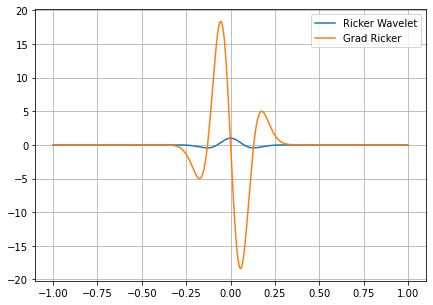

In [3]:
f = 3
pi = 3.14
precision = 500
def y(x):
    return (1-2*(pi*f*x)**2)*(-(pi*f*x)**2).exp()
x = np.linspace(-1, 1, precision)

plot(x, [((1-2*(pi*f*x)**2)*np.exp(-(pi*f*x)**2), 'Ricker Wavelet'), (grad(y)(x), 'Grad Ricker')])

**Testcase 2: Exponential**

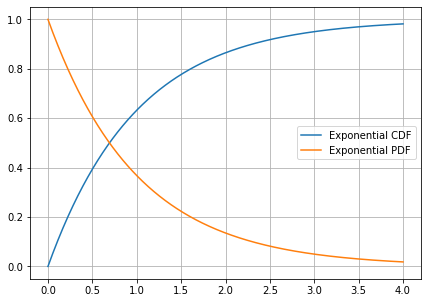

In [4]:
theta = 1
precision = 500
def y(x):
    return 1 - (-x/theta).exp()
x = np.linspace(0, 4, precision)

plot(x, [(1 - np.exp(-x/theta), 'Exponential CDF'), (grad(y)(x), 'Exponential PDF')])

**Testcase 3: Cauchy**

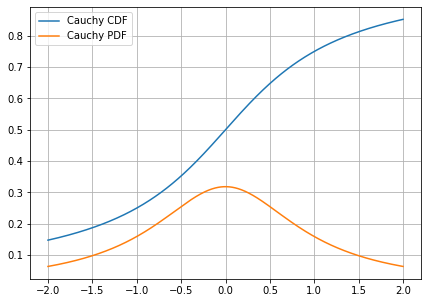

In [5]:
m = 0
d = 1
precision = 500
def y(x):
    return 1/2 + ((x-m)/d).atan()/np.pi
x = np.linspace(-2, 2, precision)

plot(x, [(1/2 + np.arctan((x-m)/d)/np.pi, 'Cauchy CDF'), (grad(y)(x), 'Cauchy PDF')])

**Testcase 4: A random function**

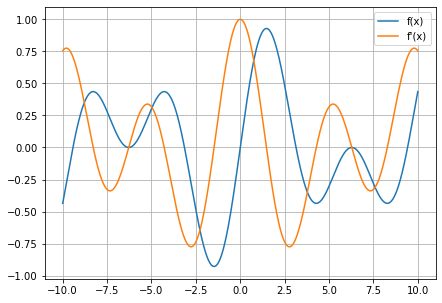

In [6]:
precision = 500
def y(x):
    return x.sin()*(x/4).cos()
x = np.linspace(-10, 10, precision)

plot(x, [(np.sin(x)*np.cos(x/4), 'f(x)'), (grad(y)(x), "f'(x)")])

## Multi Derivative

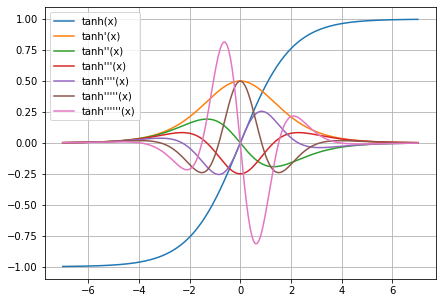

In [7]:
def tanh(x):
    return (1.0 - (-x).exp())  / (1.0 + (-x).exp())
x = np.linspace(-7, 7, 200)

plot(x, [((1.0 - np.exp(-x))  / (1.0 + np.exp(-x)), "tanh(x)"),
         (grad(tanh)(x), "tanh'(x)"),
         (grad(grad(tanh))(x), "tanh''(x)"),
         (grad(grad(grad(tanh)))(x), "tanh'''(x)"),
         (grad(grad(grad(grad(tanh))))(x), "tanh''''(x)"),
         (grad(grad(grad(grad(grad(tanh)))))(x), "tanh'''''(x)"),
         (grad(grad(grad(grad(grad(grad(tanh))))))(x), "tanh''''''(x)")])

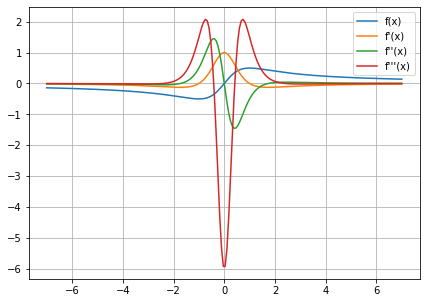

In [8]:
def f(x):
    return x / (1+x**2)
x = np.linspace(-7, 7, 200)

plot(x, [(f(x), "f(x)"),
         (grad(f)(x), "f'(x)"),
         (grad(grad(f))(x), "f''(x)"),
         (grad(grad(grad(f)))(x), "f'''(x)")])

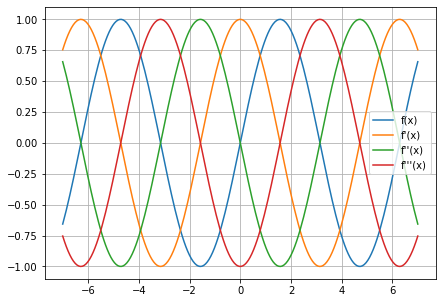

In [9]:
def f(x):
    return x.sin()
x = np.linspace(-7, 7, 200)

plot(x, [(np.sin(x), "f(x)"),
         (grad(f)(x), "f'(x)"),
         (grad(grad(f))(x), "f''(x)"),
         (grad(grad(grad(f)))(x), "f'''(x)")])

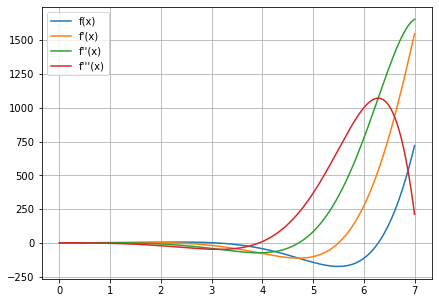

In [10]:
def f(x):
    return x.exp()*x.sin()
x = np.linspace(0, 7, 200)

plot(x, [(np.exp(x)*np.sin(x), "f(x)"),
         (grad(f)(x), "f'(x)"),
         (grad(grad(f))(x), "f''(x)"),
         (grad(grad(grad(f)))(x), "f'''(x)")])

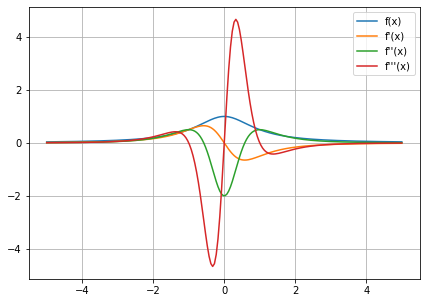

In [11]:
def f(x):
    return 1 / (1 + x**2)
x = np.linspace(-5, 5, 200)

plot(x, [(f(x), "f(x)"),
         (grad(f)(x), "f'(x)"),
         (grad(grad(f))(x), "f''(x)"),
         (grad(grad(grad(f)))(x), "f'''(x)")])